# Question 2 : Resolution analysis :
Poly:
https://josselin-garnier.org/wp-content/uploads/2025/01/polycopie-mva-2025.pdf#page=44.47

In [1]:
import numpy as np

## Hyperparameters setup

In [2]:
z=0
N=64
w0=2*np.pi 
B=np.pi/4 
zref=np.array([5,100,0])
a=20
xn=np.zeros((N,3))
# print(xn)
for n in range(N):
    xn[n][0]=-a/2+a*(n-1)/(N-1)

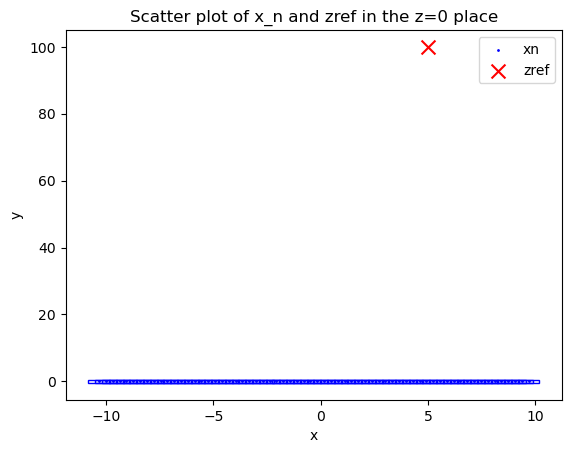

In [3]:
# Plot a two dimensional image of xn[0,1] and z_ref
import matplotlib.pyplot as plt


fig = plt.figure()
# plot xn with rectangles
plt.scatter(xn[:,0],xn[:,1],s=1,c='blue',label='xn',)
# add rectangle
for n in range(N):
    plt.gca().add_patch(plt.Rectangle((xn[n][0]-0.5,xn[n][1]-0.5),1,1,fill=False,edgecolor='blue',linewidth=1))

plt.scatter(zref[0],zref[1],s=100,c='red',label='zref',marker='x')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Scatter plot of x_n and zref in the z=0 place')
plt.legend()

In [4]:
M=64
# discretize the frequency band
f0=w0-B
f1=w0+B
fband=np.linspace(f0,f1,M)

## Définitions des fonctions importantes

In [106]:
# 1 La green function , je ne sais pas comment elle s'écrit mais on va approximer par la partie 1 (?) 

class Green:
    def __init__(self):
        # self.c0=c0,
        # self.zref=zref
        pass 
    def __call__(self,w,x,y):
        if np.ndim(x)<1:
            x=np.array([x])
            print(x.shape)
        if np.ndim(y)==1:
            y=np.array([y])
        return (1/(4*np.pi*np.linalg.norm(x-y,axis=1)))*np.exp(1j*w*np.linalg.norm(x-y,axis=1))

f=Green()
x=np.ones((N,3)) 
y=np.random.rand(N,3)
f(0,x,y).shape
# f(0,xn[0],zref)


(64,)

# Créeons les données

In [6]:
xn.shape

(64, 3)

In [107]:
rho_ref=1

class R_n:
    def __init__(self,rho_ref,f0,f1,zref,xn):
        self.rho_ref=rho_ref
        self.f0=f0
        self.f1=f1
        self.xn=xn
        self.zref=zref
        self.green=Green()
    def __call__(self,n,w):
        def rn(n,w):
            # assert w in fband
            if w<f0 or w>f1:
                print("out of f_n")
                return 0 
            
            return rho_ref*self.green(w,self.xn[n],zref)**2
        return rn(n,w)

    
R_n(rho_ref,f0,f1,zref,xn)(0,0)

out of f_n


0

(64, 1)

# créons  l'imaging Function

(1, 3) x
self.fband (64,)
(64, 3) xn
(64, 64) first term
(64, 64) R_vals
(64, 64) rn_vals
output (64, 64)
Somme_n.shape Somme_n (64,)


-3.4489454150064997e-10

In [108]:
import numpy as np

class Imagingfun:
    def __init__(self, xn, rho_ref, f0, f1, zref, fband):
        self.xn = np.array(xn)  # Convert to NumPy array for vectorized operations
        self.rho_ref = rho_ref
        self.f0 = f0
        self.f1 = f1
        self.zref = zref
        self.rn = R_n(rho_ref=rho_ref, f0=f0, f1=f1, zref=zref, xn=xn)
        self.fband = np.array(fband)  # Convert to NumPy array for vectorization
        self.M = len(fband)
        self.N = len(xn)
        self.dw = (f1 - f0) / self.M
        self.green = Green()

    def R(self, w, x, x_n):
        mask = (w >= self.f0) & (w <= self.f1)  # Boolean mask for valid frequencies
        if not np.any(mask):
            print("out of f_n for w", w)
            return 0
        return self.green(w, x_n, x) ** 2

    def __call__(self, x):
        # Compute R values in batch
        R_vals = np.array([[np.conjugate(self.R(w, x, x_n)) for w in self.fband] for x_n in self.xn])

        # Compute rn values in batch
        rn_vals = np.array([[self.rn(n, w) for w in self.fband] for n in range(self.N)])

        # Compute the integral in a vectorized manner
        Somme_n = np.sum(R_vals * rn_vals * self.dw, axis=1)

        return np.real(np.sum(Somme_n))

# Initialize Imagingfun
I_fun = Imagingfun(xn=xn, rho_ref=rho_ref, f0=f0, f1=f1, zref=zref, fband=fband)

# Call function
I_fun(zref)

3.981950399440594e-11

TypeError: R_n.__call__() takes 2 positional arguments but 3 were given

In [109]:
l_inf_x=0
l_sup_x=10

l_inf_y=80
l_sup_y=120
res=10
x=np.meshgrid(np.linspace(l_inf_x,l_sup_x,res),
               np.linspace(l_inf_y,l_sup_y,res))

In [111]:
# Compute the imaging function on the grid using vectorization
X_flat = np.column_stack((x[0].ravel(), x[1].ravel(), np.full(x[0].size, zref[2])))

# Apply the function to all points at once
I_grid_flat = np.array([I_fun(point) for point in X_flat])

# Reshape back to the original grid
I_grid = I_grid_flat.reshape(res, res)

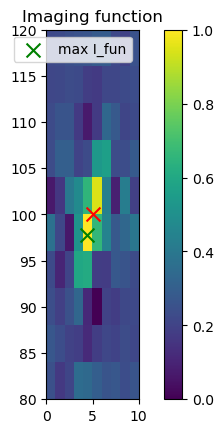

In [112]:
# plot the imaging function
fig = plt.figure()
plt.imshow(I_grid, extent=(l_inf_x,l_sup_x,l_inf_y,l_sup_y),origin='lower')
# add a point where the I_fun is maximum
max_I=np.max(I_grid)
max_I_index=np.unravel_index(np.argmax(I_grid, axis=None), I_grid.shape)
plt.scatter(x[0][max_I_index],x[1][max_I_index],s=100,c='green',label='max I_fun',marker='x')
plt.colorbar()
plt.title('Imaging function')

plt.legend()
plt.scatter(zref[0],zref[1],s=100,c='red',label='zref',marker='x')


In [15]:
x.shape
y.shape

(100, 100)

### Define the forward operator
### Define the forward operator

$$
[\hat{\mathbf{A}} \rho](\omega, x_r, x_s) = \int_{\Omega} \hat{G}_0(\omega, x_r, z) \rho(z) \hat{G}_0(\omega, z, x_s) \, dz.
$$

$$
[\hat{\mathbf{A}} \rho](\omega, x_r, x_s)=\rho_{ref} \hat{G}_{0}(\omega,x_n,z_{ref}) \hat{G}_0 ( \omega,z_{ref},x_s)
$$
page 38
On injecte l'expression de $\rho$

In [9]:
# On va maintenant défnir A 
class op_A: 
    def __init__(self,zref):
        self.zref=zref

    def __call__(self,rho):
        #,w,xr,xs
        def A(w,xr,xs):
            G0xr=Green()(w,xr,self.zref)
            G0xs=Green()(w,xs,self.zref)
            return rho*G0xr*G0xs
        return A
    
zref=zref

op1=op_A(zref=zref)
Arho=op1(rho=1)
Arho(1,5,10)
    

(-6.546291850657873e-07-3.3195889101510664e-07j)

 The adjoint operator now : 

### Here the adjoint operator is

$$
[\hat{\mathbf{A}}^* \hat{\mathbf{v}}](y) =
\sum_{r,s=1}^{N} \int d\omega \,
\overline{\hat{G}_0(\omega, y, x_r)} \hat{G}_0(\omega, x_s, y) \hat{v}(\omega, x_r, x_s).
$$

page 39

In [17]:
fband.shape

(64,)

In [36]:
class Adjoint:
    def __init__(self,xn,fband):
        self.fband=fband
        self.xn=xn
        pass
    def __call__(self,v):
        def Av(y):

            somme=0
            for r in range(len(self.xn)):
                for s in range(len(self.xn)):
                    def G0xrw(w):
                        # need to add the conjugate
                        #print("the result of G0xrw",Green()(w,y,self.xn[r]))
                        return np.conjugate(Green()(w,y,self.xn[r]))
                    def G0xsw(w):
                        #print("the result of G0xsw",Green()(w,y,self.xn[s]))
                        return Green()(w,self.xn[s],y)
                    def vw(w):
                        #print("the result of vw",v(w,self.xn[r],self.xn[s]))
                        return v(w,self.xn[r],self.xn[s])
                    # Compute the integral using numerical integration
                    def whole_integrale(w):
                        return G0xrw(w) * G0xsw(w) * vw(w)
                    f=whole_integrale
  
                    
                    integral=self.compute_integral(f,self.fband)
                    somme+= integral
            return somme
        return Av 
    def compute_integral(self,f,fband):
            # Compute the integral using numerical integration
            # Integrrate over the   frequency band fband
            result=np.zeros_like(fband,dtype=np.complex_)
            for i in range(len(fband)-1):
                #print("result",f(fband[i]))
                result[i]=f(fband[i])
            # Compute the trapezoidal rule
            integral = np.trapz(result, fband)
            return integral
    
xn_test=np.array([[0,0,0],
                 [1,1,1]])
def test(w,x,y):
    return w
vchap=test
Av=Adjoint(xn=xn_test,fband=fband)(v=vchap)
Av(5)

(0.002027227354168478+0j)

## Normal operator  
Remember that the complex conjugation in the frequency domain corresponds to the time-reversal operation in the time domain. This shows that the adjoint operator corresponds to the backpropagation of the array data both from the receiver point \( x_r \) and from the source point \( x_s \) to the test point \( y \). The normal operator is

$$
[\hat{A}^* \hat{A} \rho](y) = \int_{\Omega} dy' \, a(y, y') \rho(y'),
$$

$$
= \rho_{ref} a(y,z_{ref})
$$
with the kernel

$$
a(y, y') = \int d\omega \sum_{r,s=1}^{N} \hat{G}_0(\omega, y, x_r) \hat{G}_0(\omega, x_s, y) \overline{\hat{G}_0(\omega, y', x_r) \hat{G}_0(\omega, x_s, y')}.
$$
Normalement y'a pas besoin de tester le (test?)

In [40]:
# Normalement On a pas besoin de rien changer on compose juste les opérateurs? 
class normal_op:
    def __init__(self,Astar,A):
        self.Astar=Astar
        self.A=A
        pass
    def __call__(self,rho):

        def normal_op(y):
            return self.Astar(self.A(rho))(y)
        return normal_op

In [41]:
Astar=Adjoint(xn=xn,fband=fband)
A=op_A(zref=zref)
normal_op1=normal_op(Astar=Astar,A=A)
normal_op1(5)(5)

(-2.329494699248453e-10-1.815825882193271e-10j)

# First Method: Use the true equation



As a result, the least squares imaging function is:

$$
\mathcal{I}_{LS}(y^S) = \left[ (\hat{A}^* \hat{A})^{-1} \hat{A}^* \hat{u} \right](y^S),
$$

where \( (\hat{A}^* \hat{A})^{-1} \) is a (regularized) pseudo-inverse of the normal operator.


In [42]:

class first_imaging:
    def __init__(self,normal_op,Astar):
        self.normal_op=normal_op
        self.Astar=Astar
    
    def __call__(self, uchap):
        # invert the normal op
        def normal_op_inv(rho):
            return self.normal_op(rho) #! 
        
        def f(ys):
            first_term= self.Astar(uchap)
            second_term=normal_op_inv(first_term)
            return second_term(ys)
        return f 



In [ ]:
Astar=Adjoint(xn=xn,fband=fband)
A=op_A(zref=zref)
normal_op=normal_op(Astar=Astar,A=A)


In [ ]:
first_imaging1=first_imaging(normal_op=normal_op,Astar=Astar)



## Second Method: Reverse Time imaging function



$$
\mathcal{I}_{RT}(y^S) = \frac{1}{2\pi} \left[ \mathbf{A}^* \hat{u} \right] (y^S)
$$

aparemment ça peut s'opti avec des forwards/backwrd evaluation de G0 

## 2.3.8 Kirchhoff migration (or travel-time migration)

The Kirchhoff migration (or travel time migration) is obtained as a simplification of the reverse-time imaging function in which we take 

$$
\hat{G}_0(\omega, x, y) \simeq \exp[i\omega \mathcal{T}(x,y)],
$$

where \( \mathcal{T}(x,y) \) is the travel time from \( x \) to \( y \). Therefore, the Kirchhoff migration imaging function has the form:

$$
\mathcal{I}_{KM}(y^S) = \frac{1}{2\pi} \int d\omega \sum_{r,s=1}^{N} \exp[-i\omega (\mathcal{T}(x_r, y^S) + \mathcal{T}(x_s, y^S))] \hat{u}(\omega, x_r, x_s)
$$

$$
= \sum_{r,s=1}^{N} u(\mathcal{T}(x_r, y^S) + \mathcal{T}(x_s, y^S), x_r, x_s).
$$

(2.28)

Kirchhoff Migration (or travel time migration) has been analyzed in detail [9]. It is a simple way to triangulate the location of a reflector using an active sensor array.


### Plot and data analysis? 

Question:
Le G0 correspond t'il exactement à celui qui est exprimé dans la question 1? 
Oui
->Pour résoudre le système doit-on utilisre un solveur d'EDP?  Si la première question est vrai ,alors on devrait pas avoir beosin de resoudre le système non? 
Non du coup on fait juste une méthode des trapèze ! 
-> Attend-il qu'on fasse les trois résolutions ? ( Excat,approché/Approximative? )
Juste une méthode des trapèze de la question 2 ) 


-> A quoi correspond exactement une imaging function ? On doit donc plot la distribution des "rho_ref" possible?  
On veut juste la localisation des points, le rho_ref ne fait que modifier l'maplitude des points.


# 4. Stability analysis
TODO